### Test on 2017

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler

import optuna
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from optuna.exceptions import TrialPruned
from darts.models import BlockRNNModel
from darts.metrics import mape, mae, rmse

In [28]:
sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2012-01-01", end="2017-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)
weekly = df["Close"].resample("W-FRI").last().to_frame()

# Convert to Darts TimeSeries and fill any final missing values
series = TimeSeries.from_series(weekly["Close"], fill_missing_dates=True, freq="W")
series = fill_missing_values(series)

# Create simple time‐step covariate
time_vals = pd.Series(np.arange(len(series)), index=series.time_index)

# Split into training (up to 2016) and test (2017)
train_ts, test_ts = series.split_before(pd.Timestamp("2017-01-01"))

# Scale target
scaler = Scaler()
train_ts_s = scaler.fit_transform(train_ts)

C:\Users\USER\AppData\Local\Temp\ipykernel_22196\1817391550.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


expanding‐window (aka walk‑forward) approach

In [29]:
def get_splits(series, start_year=2012, end_year=2016):
    """
    Returns a list of (train_slice, val_slice)
    for each year from start_year to end_year inclusive.
    """
    splits = []
    for year in range(start_year, end_year):
        # Define train end and validation window
        train_end = pd.Timestamp(f"{year}-12-31")
        val_start = pd.Timestamp(f"{year+1}-01-01")
        val_end   = pd.Timestamp(f"{year+1}-12-31")

        # Explicitly use series.start_time() so both args to .slice are Timestamps
        train_slice      = series.slice(series.start_time(), train_end)
        val_slice        = series.slice(val_start,           val_end)

        splits.append((train_slice, val_slice))

    return splits

# Generate the splits for 2012–2016
splits = get_splits(train_ts, start_year=2012, end_year=2016)

In [30]:
def plot_splits_grid(splits, cols=3, figsize=None, sharex=True, sharey=True):
    n_splits = len(splits)
    rows = math.ceil(n_splits / cols)
    
    # default figsize if not provided
    if figsize is None:
        figsize = (5 * cols, 4 * rows)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize,
                             sharex=sharex, sharey=sharey)
    axes = axes.flatten()
    
    for i, (train, val) in enumerate(splits):
        ax = axes[i]
        train.plot(ax=ax, label="train")
        val.plot(ax=ax, label="validation")
        ax.set_title(f"Split {i+1}")
        ax.legend()
    
    # hide any unused axes
    for ax in axes[n_splits:]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()

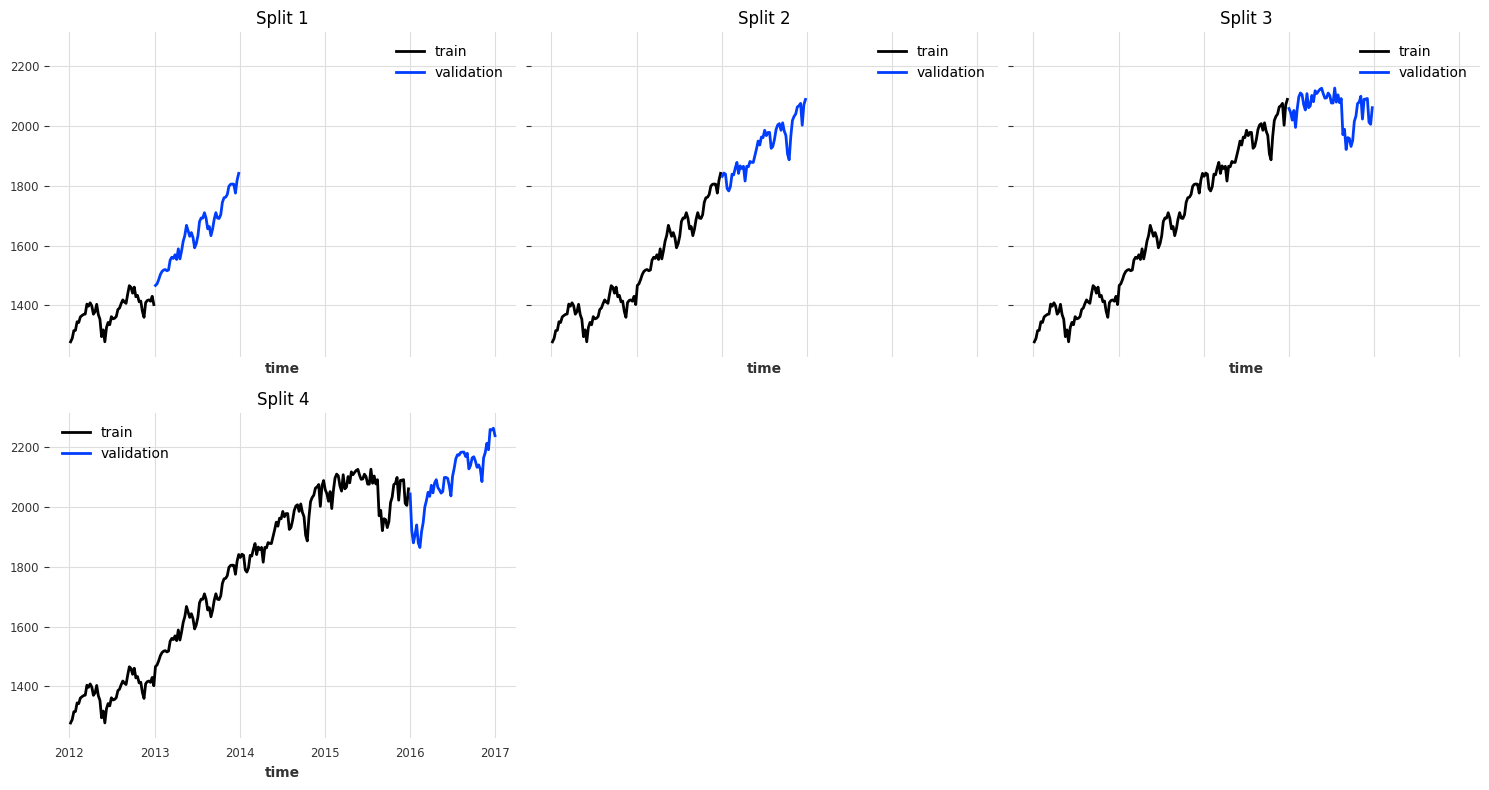

In [22]:
plot_splits_grid(splits)

### Start tuning

time‑series cross‑validation (also called walk‑forward validation) across the years

In [31]:
min_train_len = min(len(train_i) for train_i, _ in splits)
max_input_len = min_train_len - 1 # since output_chunk_length = 1

# Define Optuna objective
def objective(trial):
    # Sample hyperparameters
    input_len = trial.suggest_int("input_chunk_length", 4, max_input_len)
    hidden    = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    n_layers  = trial.suggest_int("n_rnn_layers", 1, 3)
    lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    dropout   = trial.suggest_float("dropout", 0.0, 0.5)

    fold_errors = []
    for fold_idx, (train_i, val_i) in enumerate(splits):
        # Scale this fold’s data
        scaler_i = Scaler()
        t_i = scaler_i.fit_transform(train_i)
        v_i = scaler_i.transform(val_i)

        # Build a Lightning Trainer (double precision + early stopping)
        early_stop = EarlyStopping(
            monitor="val_loss",
            patience=5,
            mode="min",
            verbose=False,
        )
        trainer = pl.Trainer(
            accelerator="gpu",
            devices=1,
            precision=64,
            max_epochs=50,
            callbacks=[early_stop],
            enable_checkpointing=False,
            enable_progress_bar=False,
            logger=False,
        )

        # Instantiate & fit the LSTM model (no covariates)
        model = BlockRNNModel(
            model="LSTM",
            input_chunk_length=input_len,
            output_chunk_length=1,
            hidden_dim=hidden,
            n_rnn_layers=n_layers,
            dropout=dropout,
            batch_size=32,
            optimizer_kwargs={"lr": lr},
            nr_epochs_val_period=1,
            random_state=42,
        )
        model.fit(
            series=t_i,
            val_series=v_i,
            trainer=trainer,
            verbose=False,
        )

        # Forecast & compute MAPE
        pred_s = model.predict(n=len(v_i), series=t_i)
        pred = scaler_i.inverse_transform(pred_s)
        error = mape(val_i, pred)
        fold_errors.append(error)

        # Report intermediate error and prune if needed
        trial.report(error, step=fold_idx)
        if trial.should_prune():
            raise TrialPruned()

    # Return mean error across all folds
    return float(np.mean(fold_errors))


In [32]:
# Run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
print("Best hyperparameters:", study.best_params)

[I 2025-08-02 20:15:18,963] A new study created in memory with name: no-name-61abd8eb-a6ae-41e3-acd0-9262c252efe0
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23437523948178707 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
------------------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23437523948178707 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 265 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23437523948178707 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 265 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23437523948178707 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 265 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:20,954] Trial 0 finished with value: 13.073376883800014 and parameters: {'input_chunk_length': 36, 'hidden_dim': 256, 'n_rnn_layers': 1, 'lr': 0.0004688010175699333, 'dropout': 0.23437523948178707}. Best is trial 0 with value: 13.073376883800014.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criteri

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:27,053] Trial 1 finished with value: 13.464149761221627 and parameters: {'input_chunk_length': 31, 'hidden_dim': 256, 'n_rnn_layers': 2, 'lr': 0.0001303963411974071, 'dropout': 0.07494911988776198}. Best is trial 0 with value: 13.073376883800014.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criteri

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), 

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:29,418] Trial 2 finished with value: 16.110970155349797 and parameters: {'input_chunk_length': 4, 'hidden_dim': 64, 'n_rnn_layers': 2, 'lr': 0.00022206934353805906, 'dropout': 0.19883266497130253}. Best is trial 0 with value: 13.073376883800014.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterio

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
331 K     Trainable params
0         Non-trainable params
331 K     Total params
1.326     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:33,278] Trial 3 finished with value: 13.044890259829664 and parameters: {'input_chunk_length': 44, 'hidden_dim': 128, 'n_rnn_layers': 3, 'lr': 0.00028046130548057364, 'dropout': 0.24262237436054218}. Best is trial 3 with value: 13.044890259829664.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criter

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:35,218] Trial 4 finished with value: 14.748385778517024 and parameters: {'input_chunk_length': 44, 'hidden_dim': 64, 'n_rnn_layers': 3, 'lr': 0.0015739368823622407, 'dropout': 0.28806280893318253}. Best is trial 3 with value: 13.044890259829664.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterio

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:38,995] Trial 5 finished with value: 13.145042717726618 and parameters: {'input_chunk_length': 39, 'hidden_dim': 128, 'n_rnn_layers': 2, 'lr': 0.00017090678743267554, 'dropout': 0.037380865664436935}. Best is trial 3 with value: 13.044890259829664.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_crite

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:39,292] Trial 6 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc       

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:40,899] Trial 7 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.48437335271223264 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      |

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:41,048] Trial 8 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4266377308567891 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | 

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:41,246] Trial 9 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 331 K  | train
6 | fc       

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:41,478] Trial 10 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.21102029022369959 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:41,746] Trial 11 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3280718926269178 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      |

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:42,077] Trial 12 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc      

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:42,784] Trial 13 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc      

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:43,231] Trial 14 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc      

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:49,043] Trial 15 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14579059381731213 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:49,522] Trial 16 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc      

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:49,916] Trial 17 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc      

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:50,619] Trial 18 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18156275526807716 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18156275526807716 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18156275526807716 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18156275526807716 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:52,413] Trial 19 finished with value: 12.460375154978495 and parameters: {'input_chunk_length': 26, 'hidden_dim': 128, 'n_rnn_layers': 1, 'lr': 0.0003004584531447728, 'dropout': 0.18156275526807716}. Best is trial 19 with value: 12.460375154978495.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_crite

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:54,790] Trial 20 finished with value: 13.109771884570723 and parameters: {'input_chunk_length': 24, 'hidden_dim': 128, 'n_rnn_layers': 2, 'lr': 0.00026745987900449094, 'dropout': 0.003002585666179669}. Best is trial 19 with value: 12.460375154978495.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19722153309519375 and num_layers=1
 

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19722153309519375 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19722153309519375 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:55,989] Trial 21 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23963286595435163 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:56,249] Trial 22 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17481305070325787 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17481305070325787 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17481305070325787 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17481305070325787 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:15:59,085] Trial 23 finished with value: 11.257605007835348 and parameters: {'input_chunk_length': 44, 'hidden_dim': 128, 'n_rnn_layers': 1, 'lr': 0.00017244873936609844, 'dropout': 0.17481305070325787}. Best is trial 23 with value: 11.257605007835348.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17630511020914486 and num_layers=1
  

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17630511020914486 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17630511020914486 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17630511020914486 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:16:02,158] Trial 24 finished with value: 10.709903077247363 and parameters: {'input_chunk_length': 51, 'hidden_dim': 128, 'n_rnn_layers': 1, 'lr': 0.00016982626005626082, 'dropout': 0.17630511020914486}. Best is trial 24 with value: 10.709903077247363.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10892964458733838 and num_layers=1
  

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10892964458733838 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10892964458733838 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10892964458733838 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:16:05,466] Trial 25 finished with value: 9.573569874250278 and parameters: {'input_chunk_length': 50, 'hidden_dim': 128, 'n_rnn_layers': 1, 'lr': 0.00017282003202799103, 'dropout': 0.10892964458733838}. Best is trial 25 with value: 9.573569874250278.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.08181102914731421 and num_layers=1
  wa

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:16:05,918] Trial 26 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12283514476692309 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:16:06,429] Trial 27 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10671903325307322 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10671903325307322 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10671903325307322 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10671903325307322 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:16:09,386] Trial 28 finished with value: 9.700814627052319 and parameters: {'input_chunk_length': 48, 'hidden_dim': 128, 'n_rnn_layers': 1, 'lr': 0.00018145948989159604, 'dropout': 0.10671903325307322}. Best is trial 25 with value: 9.573569874250278.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.041052209814947616 and num_layers=1
  w

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.041052209814947616 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.041052209814947616 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.041052209814947616 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:16:12,197] Trial 29 finished with value: 10.59229806765155 and parameters: {'input_chunk_length': 48, 'hidden_dim': 128, 'n_rnn_layers': 1, 'lr': 0.00019996103863307893, 'dropout': 0.041052209814947616}. Best is trial 25 with value: 9.573569874250278.


Best hyperparameters: {'input_chunk_length': 50, 'hidden_dim': 128, 'n_rnn_layers': 1, 'lr': 0.00017282003202799103, 'dropout': 0.10892964458733838}


### Best params to model for test set
That final model has just one set of learned weights, trained on the full data, with the hyperparameters that gave the best average performance across your cross‐validation splits.

In [33]:
# Unpack best params
best = study.best_params
best

{'input_chunk_length': 50,
 'hidden_dim': 128,
 'n_rnn_layers': 1,
 'lr': 0.00017282003202799103,
 'dropout': 0.10892964458733838}

In [34]:
# Final model on full train_ts
final_model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=best["input_chunk_length"],
    output_chunk_length=1,
    hidden_dim=best["hidden_dim"],
    n_rnn_layers=best["n_rnn_layers"],
    dropout=best["dropout"],
    batch_size=32,
    n_epochs=100,
    optimizer_kwargs={"lr": best["lr"]},
    nr_epochs_val_period=5,
    pl_trainer_kwargs={"accelerator": "gpu", "devices": 1},
    random_state=42
)

# Fit on full 2010–2016
train_full_s = scaler.fit_transform(train_ts)
final_model.fit(train_full_s, verbose=True)

# Forecast 2017
forecast_s = final_model.predict(
    n=len(test_ts),
    series=train_full_s
)
forecast = scaler.inverse_transform(forecast_s)


c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10892964458733838 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

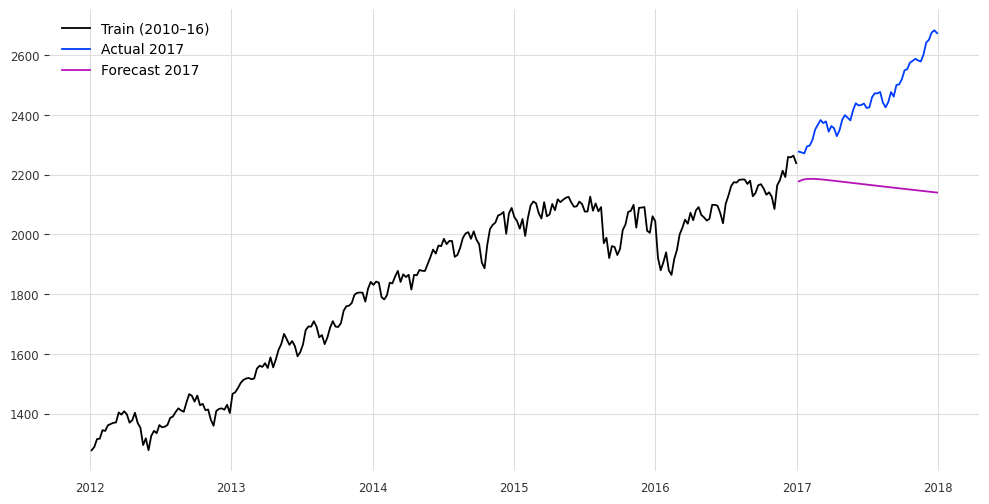

Test MAPE: 11.45%
Test MAE:  285.71
Test RMSE: 311.67


In [35]:
# Plot and metrics
plt.figure(figsize=(12,6))

plt.plot(train_ts.time_index, train_ts.values(), label="Train (2010–16)")
plt.plot(test_ts.time_index, test_ts.values(), label="Actual 2017")
plt.plot(forecast.time_index, forecast.values(), label="Forecast 2017")
plt.legend()
plt.show()

print(f"Test MAPE: {mape(test_ts, forecast):.2f}%")
print(f"Test MAE:  {mae(test_ts, forecast):.2f}")
print(f"Test RMSE: {rmse(test_ts, forecast):.2f}")

### Forecast on 2023

In [36]:
df = sp500.history(start="2014-01-01", end="2024-01-01")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)
weekly = df["Close"].resample("W-FRI").last().to_frame()

# Convert to Darts TimeSeries and fill any final missing values
series = TimeSeries.from_series(weekly["Close"], fill_missing_dates=True, freq="W")
series = fill_missing_values(series)

# Create simple time‐step covariate
time_vals = pd.Series(np.arange(len(series)), index=series.time_index)

# Split into training and test
train_ts, test_ts = series.split_before(pd.Timestamp("2023-01-01"))

# Scale target
scaler = Scaler()
train_ts_s = scaler.fit_transform(train_ts)

C:\Users\USER\AppData\Local\Temp\ipykernel_22196\2793793907.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [37]:
# Generate the splits for 2014 - 2022
splits = get_splits(train_ts, start_year=2014, end_year=2022)

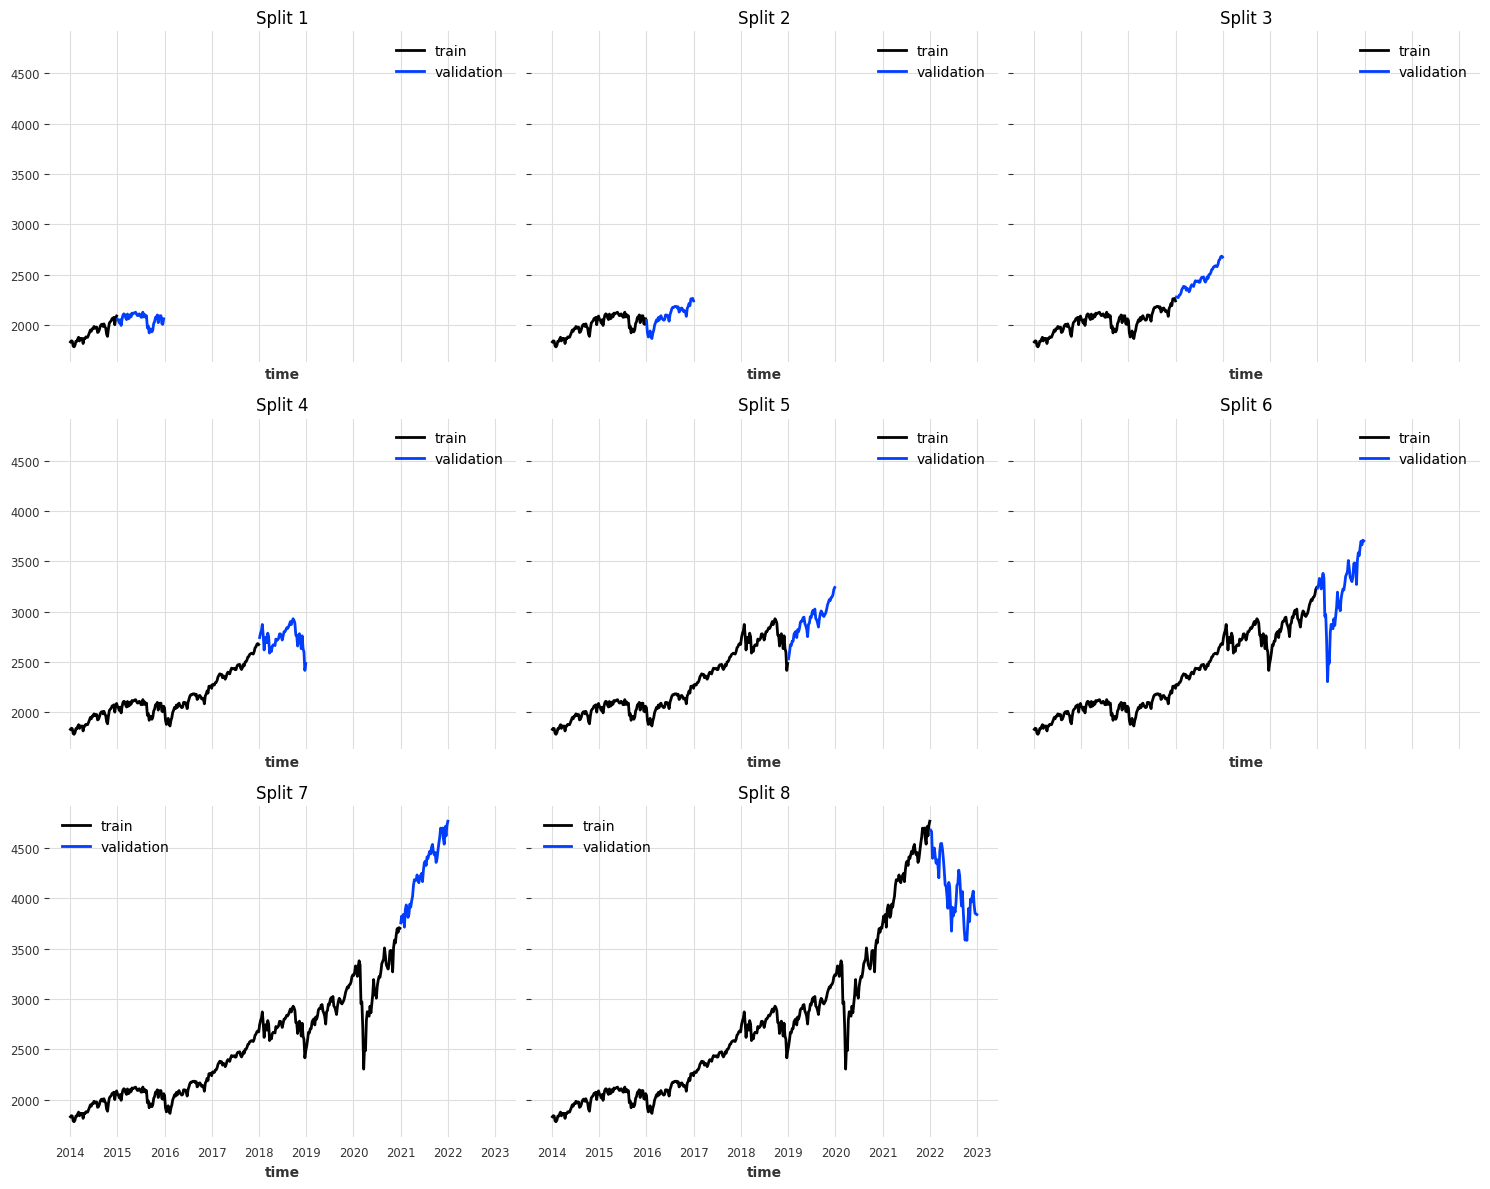

In [38]:
plot_splits_grid(splits)

In [ ]:
min_train_len = min(len(train_i) for train_i, _ in splits)
max_input_len = min_train_len - 1 # since output_chunk_length = 1

# Run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-08-02 20:27:24,739] A new study created in memory with name: no-name-80ad0653-1f7a-42fb-8cad-d3e40d838fb7
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:27:38,073] Trial 0 finished with value: 13.170233560790887 and parameters: {'input_chunk_length': 47, 'hidden_dim': 64, 'n_rnn_layers': 3, 'lr': 0.00017321685461160486, 'dropout': 0.15442772965723534}. Best is trial 0 with value: 13.170233560790887.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criteri

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 791 K  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.167     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:27:49,052] Trial 1 finished with value: 81.41906831957029 and parameters: {'input_chunk_length': 9, 'hidden_dim': 256, 'n_rnn_layers': 2, 'lr': 0.00010190112563456911, 'dropout': 0.24769303041577206}. Best is trial 0 with value: 13.170233560790887.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterio

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:28:18,652] Trial 2 finished with value: 30.426540728965737 and parameters: {'input_chunk_length': 19, 'hidden_dim': 256, 'n_rnn_layers': 3, 'lr': 0.00011115001898309728, 'dropout': 0.0041152946210959995}. Best is trial 0 with value: 13.170233560790887.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_crit

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc              | Sequential       | 257    | train
-------------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.273     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:28:52,488] Trial 3 finished with value: 11.435728014295016 and parameters: {'input_chunk_length': 49, 'hidden_dim': 256, 'n_rnn_layers': 3, 'lr': 0.0022529106742493893, 'dropout': 0.29889591147105204}. Best is trial 3 with value: 11.435728014295016.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criteri

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:29:05,046] Trial 4 finished with value: 10.47604131133145 and parameters: {'input_chunk_length': 40, 'hidden_dim': 64, 'n_rnn_layers': 3, 'lr': 0.0002237550978822088, 'dropout': 0.21598644128844113}. Best is trial 4 with value: 10.47604131133145.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion 

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 199 K  | train
6 | fc              | Sequential       | 129    | train
-------------------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:29:17,340] Trial 5 finished with value: 15.788115965180127 and parameters: {'input_chunk_length': 48, 'hidden_dim': 128, 'n_rnn_layers': 2, 'lr': 0.0009480558271807651, 'dropout': 0.2745471820388237}. Best is trial 4 with value: 10.47604131133145.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:29:18,486] Trial 6 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc       

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:29:19,416] Trial 7 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc       

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 83.7 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
83.8 K    Trainable params
0         Non-trainable params
83.8 K    Total params
0.335     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:29:27,976] Trial 8 finished with value: 11.457984324827521 and parameters: {'input_chunk_length': 21, 'hidden_dim': 64, 'n_rnn_layers': 3, 'lr': 0.00035008821146517103, 'dropout': 0.1075821999954727}. Best is trial 4 with value: 10.47604131133145.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:29:28,277] Trial 9 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16026213668141226 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      |

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16026213668141226 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16026213668141226 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16026213668141226 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16026213668141226 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16026213668141226 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16026213668141226 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16026213668141226 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 67.1 K | train
6 | fc              | Sequential       | 129    | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:29:34,790] Trial 10 finished with value: 31.83223121891021 and parameters: {'input_chunk_length': 35, 'hidden_dim': 128, 'n_rnn_layers': 1, 'lr': 0.0007440635925825438, 'dropout': 0.16026213668141226}. Best is trial 4 with value: 10.47604131133145.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.36387688369314347 and num_layers=1
  warn

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:29:35,042] Trial 11 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | fc      

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:29:35,636] Trial 12 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc      

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:29:43,286] Trial 13 finished with value: 9.945166416122623 and parameters: {'input_chunk_length': 33, 'hidden_dim': 64, 'n_rnn_layers': 2, 'lr': 0.0016165632564120438, 'dropout': 0.37693822000866806}. Best is trial 13 with value: 9.945166416122623.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterio

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:29:53,357] Trial 14 finished with value: 12.520454262148615 and parameters: {'input_chunk_length': 30, 'hidden_dim': 64, 'n_rnn_layers': 2, 'lr': 0.0004617155655058343, 'dropout': 0.39429751970173804}. Best is trial 13 with value: 9.945166416122623.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20178741435728287 and num_layers=1
  war

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20178741435728287 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20178741435728287 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20178741435728287 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20178741435728287 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20178741435728287 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20178741435728287 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20178741435728287 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:29:58,806] Trial 15 finished with value: 10.015130966198026 and parameters: {'input_chunk_length': 34, 'hidden_dim': 64, 'n_rnn_layers': 1, 'lr': 0.001436365853537675, 'dropout': 0.20178741435728287}. Best is trial 13 with value: 9.945166416122623.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.42786347549045506 and num_layers=1
  warn

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.42786347549045506 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.42786347549045506 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.42786347549045506 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.42786347549045506 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.42786347549045506 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.42786347549045506 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.42786347549045506 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:30:04,397] Trial 16 finished with value: 11.465208881094874 and parameters: {'input_chunk_length': 33, 'hidden_dim': 64, 'n_rnn_layers': 1, 'lr': 0.0015049260495477315, 'dropout': 0.42786347549045506}. Best is trial 13 with value: 9.945166416122623.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.062068066888814444 and num_layers=1
  wa

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:30:04,620] Trial 17 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17437258457952953 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:30:04,898] Trial 18 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc      

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:30:05,292] Trial 19 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc      

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:30:13,247] Trial 20 finished with value: 10.419627856949987 and parameters: {'input_chunk_length': 26, 'hidden_dim': 64, 'n_rnn_layers': 2, 'lr': 0.0006597498494983326, 'dropout': 0.3862169172406639}. Best is trial 13 with value: 9.945166416122623.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterio

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:30:21,278] Trial 21 finished with value: 12.591212087408806 and parameters: {'input_chunk_length': 26, 'hidden_dim': 64, 'n_rnn_layers': 2, 'lr': 0.0006175063530237065, 'dropout': 0.3983492574654713}. Best is trial 13 with value: 9.945166416122623.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterio

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:30:21,618] Trial 22 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc      

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU co

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:30:30,416] Trial 23 finished with value: 10.819367571174169 and parameters: {'input_chunk_length': 31, 'hidden_dim': 64, 'n_rnn_layers': 2, 'lr': 0.0007155033812742378, 'dropout': 0.49344032761713935}. Best is trial 13 with value: 9.945166416122623.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  war

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:30:36,251] Trial 24 finished with value: 9.13148089835144 and parameters: {'input_chunk_length': 44, 'hidden_dim': 64, 'n_rnn_layers': 1, 'lr': 0.002225936957566472, 'dropout': 0.32288433211338097}. Best is trial 24 with value: 9.13148089835144.
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2993500228009908 and num_layers=1
  warnings

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:30:36,509] Trial 25 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.34256193259559986 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:30:36,820] Trial 26 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22419081293144885 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:30:37,231] Trial 27 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3085763001840893 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      |

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:30:37,635] Trial 28 pruned. 
C:\Users\USER\AppData\Local\Temp\ipykernel_22196\3370188852.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr        = trial.suggest_loguniform("lr", 1e-4, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.11187100502605327 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.11187100502605327 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.11187100502605327 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.11187100502605327 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.11187100502605327 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.11187100502605327 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.11187100502605327 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.11187100502605327 and num_layers=1
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-08-02 20:30:44,620] Trial 29 finished with value: 9.339093854330258 and parameters: {'input_chunk_length': 36, 'hidden_dim': 64, 'n_rnn_layers': 1, 'lr': 0.0010315987600787357, 'dropout': 0.11187100502605327}. Best is trial 24 with value: 9.13148089835144.


In [41]:
# Unpack best params
best = study.best_params
print("Best hyperparameters:", best)

Best hyperparameters: {'input_chunk_length': 44, 'hidden_dim': 64, 'n_rnn_layers': 1, 'lr': 0.002225936957566472, 'dropout': 0.32288433211338097}


In [42]:
# Final model on full train_ts
final_model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=best["input_chunk_length"],
    output_chunk_length=1,
    hidden_dim=best["hidden_dim"],
    n_rnn_layers=best["n_rnn_layers"],
    dropout=best["dropout"],
    batch_size=32,
    n_epochs=100,
    optimizer_kwargs={"lr": best["lr"]},
    nr_epochs_val_period=5,
    pl_trainer_kwargs={"accelerator": "gpu", "devices": 1},
    random_state=42
)

# Fit
train_full_s = scaler.fit_transform(train_ts)
final_model.fit(train_full_s, verbose=True)

# Forecast
forecast_s = final_model.predict(
    n=len(test_ts),
    series=train_full_s
)
forecast = scaler.inverse_transform(forecast_s)

c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 17.2 K | train
6 | fc              | Sequential       | 65     | train
-------------------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

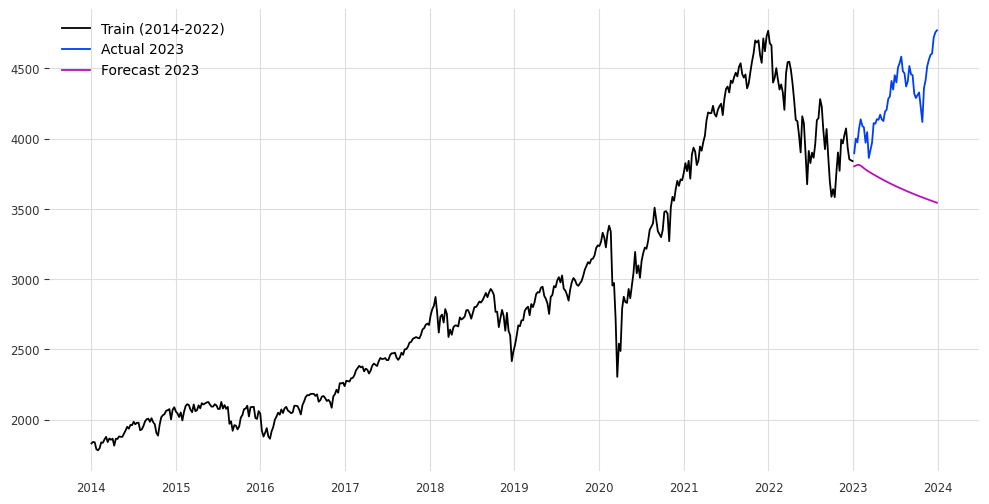

Test MAPE: 14.14%
Test MAE:  620.97
Test RMSE: 690.45


In [43]:
# Plot and metrics
plt.figure(figsize=(12,6))

plt.plot(train_ts.time_index, train_ts.values(), label="Train (2014-2022)")
plt.plot(test_ts.time_index, test_ts.values(), label="Actual 2023")
plt.plot(forecast.time_index, forecast.values(), label="Forecast 2023")
plt.legend()
plt.show()

print(f"Test MAPE: {mape(test_ts, forecast):.2f}%")
print(f"Test MAE:  {mae(test_ts, forecast):.2f}")
print(f"Test RMSE: {rmse(test_ts, forecast):.2f}")

### Backtest on 2023 and 2024

In [44]:
scaler = Scaler()
series_s = scaler.fit_transform(series)

In [45]:
# Final model on full train_ts
final_model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=best["input_chunk_length"],
    output_chunk_length=1,
    hidden_dim=best["hidden_dim"],
    n_rnn_layers=best["n_rnn_layers"],
    dropout=best["dropout"],
    batch_size=32,
    n_epochs=100,
    optimizer_kwargs={"lr": best["lr"]},
    nr_epochs_val_period=5,
    pl_trainer_kwargs={"accelerator": "gpu", "devices": 1},
    random_state=42
)


# Define backtest period
backtest_start = pd.Timestamp("2023-01-01")
h = len(series[backtest_start:]) # length of backtest period

In [46]:
# Run the historical forecasts
dl_backtest_s = final_model.historical_forecasts(
    series          = series_s,
    start           = backtest_start,
    forecast_horizon= 1,       # one week ahead
    stride          = 1,       # move by 1 period each fold
    retrain         = True,    # re-fit at each fold
    last_points_only= True,    # keep only the 1-step point per fold
    verbose         = False
)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection |

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32288433211338097 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [47]:
# Inverse transform
dl_backtest = scaler.inverse_transform(dl_backtest_s)

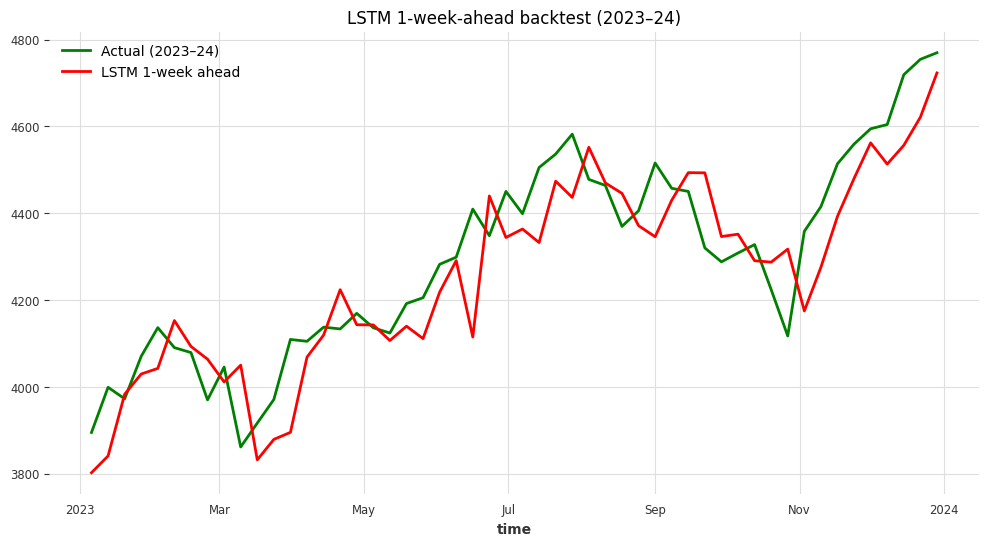

MAPE: 2.01%
MAE:  86.48
RMSE: 107.33


In [48]:
actuals_bt = series[backtest_start:]

plt.figure(figsize=(12,6))
actuals_bt.plot(label="Actual (2023–24)", color="green")
dl_backtest.plot(label="LSTM 1-week ahead", color="red")
plt.legend()
plt.title("LSTM 1-week-ahead backtest (2023–24)")
plt.show()

print(f"MAPE: {mape(actuals_bt, dl_backtest):.2f}%")
print(f"MAE:  {mae (actuals_bt, dl_backtest):.2f}")
print(f"RMSE: {rmse(actuals_bt, dl_backtest):.2f}")

In [49]:
from sklearn.metrics import precision_score

# convert both to pandas Series for easy shifting/alignment
pred = dl_backtest.to_series() # one-week-ahead forecasts
actual = actuals_bt.to_series() # the real weekly closes

# get last week’s actual price at each forecast date
prev_price = actual.shift(1)

# drop the very first point where prev_price is NaN
mask = prev_price.notna()
pred = pred[mask]
actual = actual[mask]
prev_price = prev_price[mask]

# compute predicted & actual directions: +1 for up, -1 for down
pred_dir   = np.where(pred   > prev_price,  1, -1)
actual_dir = np.where(actual > prev_price,  1, -1)

# compute directional accuracy
dir_acc = (pred_dir == actual_dir).mean() * 100
print(f"Directional accuracy: {dir_acc:.2f}%")

# compute precision for the "up" class
y_pred = (pred_dir == 1)
y_true = (actual_dir == 1)
precision = precision_score(y_true, y_pred) * 100
print(f"Precision (stock actually increase): {precision:.2f}%")

Directional accuracy: 43.14%
Precision (stock actually increase): 55.00%
